In [17]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib  as mpl
import numpy as np
import scipy.stats as ss
from scipy import optimize
import matplotlib.dates as mdates
import matplotlib.ticker as tk
import matplotlib as mpl
from statsmodels.tsa.ar_model import AutoReg

In [18]:
data = pd.read_csv('time-series.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [19]:
%matplotlib inline                            #magic
mpl.rcParams['font.family'] = 'times new roman'
plt.rcParams['figure.dpi'] = 600
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.figsize'] = (20, 10)

UsageError: unrecognized arguments: #magic


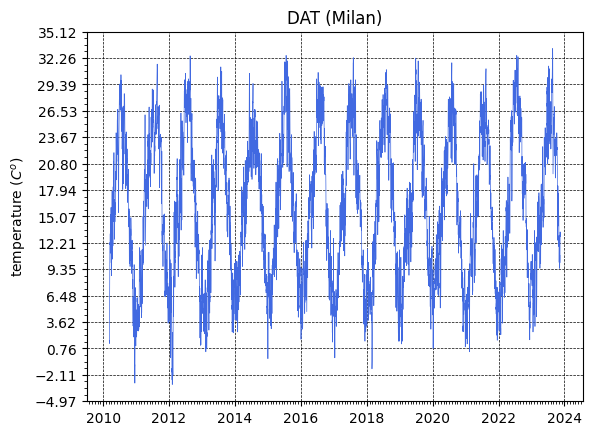

In [20]:
plot = plt.subplot2grid((2,4), (0,0), rowspan=2, colspan=4)
plot.plot(data['DAT'][-5000:].index, data['DAT'][-5000:], lw=0.5, c='royalblue', ls='-')       # -5000= ultime 5000 osservazioni
plot.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
plot.yaxis.set_major_locator(tk.LinearLocator(numticks=15))
plot.yaxis.set_minor_locator(tk.AutoMinorLocator())

plt.title('DAT (Milan)')
plt.ylabel('temperature $(C^o)$')
plt.xlabel('')
plt.grid(color='black', ls='--', lw=0.5)

plt.show()

In [21]:
data

,max,min,DAT
date,,,
1763-01-01,-3.6,-5.0,-4.30
1763-01-02,-2.6,-4.0,-3.30
1763-01-03,-0.9,-2.9,-1.90
1763-01-04,-0.4,-2.4,-1.40
1763-01-05,2.1,0.1,1.10
...,...,...,...
2023-11-12,12.7,7.4,10.05
2023-11-13,14.3,6.7,10.50
2023-11-14,12.5,10.8,11.65


beta 0: 12.337810479118946
beta 1: 2.3877585146738103e-05
beta 2: -9.054743369189045e-11
a: -6.478413741796561
b: -4.801125136935769
rho: -0.09913755136629614
phi: 7.4336141521502


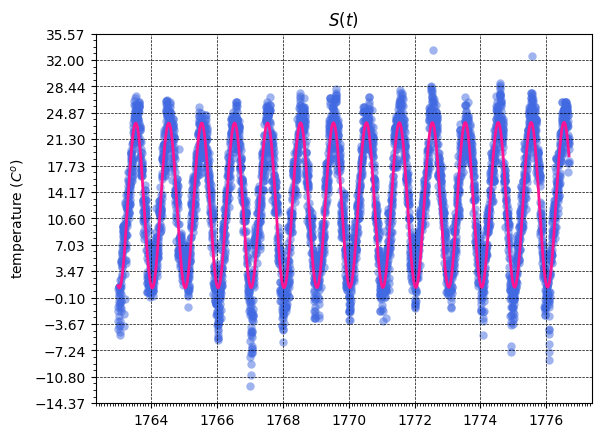

In [22]:
data['t'] = np.arange(len(data))

lookback = -5000    # Select lookback period

def model(x, b0, b1, b2, a_coefficients, b_coefficients, rho, phi):           #troncated fourier
    om = 2*np.pi/365.25
    S = b0 + b1*x + b2*(x**2)

    for m in range(len(a_coefficients)):
        S += a_coefficients[m+1]*np.cos((m+1)*om*x + rho)

    for n in range(len(b_coefficients)):
        S += b_coefficients[n+1]*np.sin((n+1)*om*x + phi)
    
    return S

def model1(x, b0, b1, b2, a, b, rho, phi):
    om = 2 * np.pi / 365.25
    S = b0 + b1*x + b2*(x**2) + a*np.cos(om*x + rho) + b*np.sin(om*x + phi)
    return S

params, params_cov = optimize.curve_fit(model1, data['t'], data['DAT'], [0,0,0,0,0,0,0])

b0, b1, b2, a, b, rho, phi = params

print(f'beta 0: {b0}')
print(f'beta 1: {b1}')
print(f'beta 2: {b2}')
print(f'a: {a}')
print(f'b: {b}')
print(f'rho: {rho}')
print(f'phi: {phi}')

data['seasonal'] = model1(data['t'], *params)

fig, ax = plt.subplots()

ax.scatter(data['DAT'][:-lookback].index, data['DAT'][:-lookback], color='royalblue', marker='o', alpha=0.5, linewidths=0.01)
ax.plot(data['DAT'][:-lookback].index, data['seasonal'][:-lookback], color='deeppink', ls='-', lw=2)
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
ax.yaxis.set_major_locator(tk.LinearLocator(numticks=15))
ax.yaxis.set_minor_locator(tk.AutoMinorLocator())

plt.title('$S(t)$')
plt.xlabel('')
plt.ylabel('temperature $(C^o)$')
plt.grid(color='black', linestyle='--', lw=0.5)

plt.show()

In [23]:
data['c'] = data['DAT'] - data['seasonal']

cyc = pd.DataFrame(data['c'])
cyc = cyc.asfreq('d')

ar = AutoReg(cyc, lags=1, trend='n').fit()
coef = ar.params
ar_res = ar.resid

kappa = -np.log(coef)

cyc['ar_res'] = ar_res
cyc['ar_res^2'] = ar_res ** 2      # res=residuali

ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      c   No. Observations:                95283
Model:                     AutoReg(1)   Log Likelihood             -180724.395
Method:               Conditional MLE   S.D. of innovations              1.613
Date:                Mon, 22 Jan 2024   AIC                         361452.789
Time:                        16:19:48   BIC                         361471.718
Sample:                    01-02-1763   HQIC                        361458.546
                         - 11-16-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c.L1           0.8310      0.002    461.163      0.000       0.827       0.835
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2034           +0.0000j            1.2034            0.0000
-----------------------------------------------------------------------------
"""

c: 8.415114884109446
d1: 1.1033458305249046
d2: 0.26406231744260994
d3: 0.3229951156586459
e1: 0.5127526087697725
e2: 1.6061990059143842
e3: 0.28966721149471464


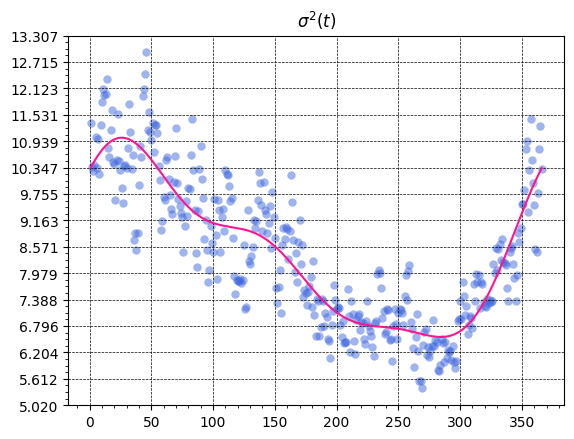

In [24]:
vol = pd.DataFrame(data['DAT'], index=data.index)

vol['day'] = vol.index.dayofyear
vol['year'] = vol.index.year

vol = vol.pivot(values='DAT', index='year', columns='day')

var = (vol.std(axis=0))**2

def model2(x, c, d1, d2, d3, e1, e2, e3):
    om = 2*np.pi/365.25
    sigma = c + d1*np.cos(om*x) + e1*np.sin(om*x) + d2*np.cos(2*om*x) + e2*np.sin(2*om*x) + d3*np.cos(3*om*x) + e3*np.sin(3*om*x)
    return sigma

params2, params_cov2 = optimize.curve_fit(model2, var.index, var, [0, 0, 0, 0, 0, 0, 0])

c, d1, e1, d2, e2, d3, e3 = params2

print(f'c: {c}')
print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'd3: {d3}')
print(f'e1: {e1}')
print(f'e2: {e2}')
print(f'e3: {e3}')

sigma = pd.DataFrame(index=var.index)

sigma['sigma2'] = model2(var.index, *params2)

fig, ax = plt.subplots()


ax.scatter(var.index, var, color='royalblue', marker='o', alpha=0.5, linewidths=0.01)
ax.plot(sigma.index, sigma['sigma2'], color='deeppink', ls='-', lw=1.5)
ax.xaxis.set_minor_locator(tk.AutoMinorLocator())
ax.yaxis.set_major_locator(tk.LinearLocator(numticks=15))
ax.yaxis.set_minor_locator(tk.AutoMinorLocator())

plt.title('$\sigma^2(t)$')
plt.xlabel('')
plt.ylabel('')
plt.grid(color='black', linestyle='--', lw=0.5)

plt.show()

In [25]:
from scipy.integrate import quad

In [26]:
# Estimated Parameters
beta_0 = 12.337810479118946
beta_1 = 2.3877585146738103e-05
beta_2 = -9.054743369189045e-11
a = -6.478413741796561
b = -4.801125136935769
rho = -0.09913755136629614
phi = 7.4336141521502
c = 8.41511489204595
d = [1.1033458364717825, 0.26406233591172934, 0.3229951273761424]
e = [0.5127525941648733, 1.6061990138097273, 0.2896672246728045]
kappa = 0.185112
omega = 2*np.pi/365.25

In [27]:
def sigma2(t):
    return c + d[0] * np.cos(omega * (t)) + e[0] * np.sin(omega * (t)) + d[1] * np.cos(2 * omega * (t)) + e[1] * np.sin(2 * omega * (t)) + d[2] * np.cos(3 * omega * (t)) + e[2] * np.sin(3 * omega * (t))

def integrand(u, t, kappa):
    return np.exp(-2 * kappa * (t - (u))) * sigma2(u)

In [28]:
# Quasi-Random simulation (same seed draws the same numbers)
np.random.seed(seed=100)

Time = 365      # Time to maturity
delta_t = 1     # delta t
N = int((Time+1)/delta_t) 
M = 200000      # Number of simulations

T0 = 10         # Initial temperature (at T0)
t0 = (dt.datetime(1763,1,1)-dt.datetime.now()).days

# Vectors of Values
T_values = np.zeros((M, N))
S_values = np.zeros(N)
sigma2_values = np.zeros(N)
T_values[:,0] = T0

# Random matrix
W = ss.norm.rvs(loc=0, scale=1, size=(M, N-1))

for t in range(0, N):
    S_values[t] = beta_0 + beta_1*(t+t0) + beta_2*((t+t0)**2) + a * np.cos(omega * (t+t0) + rho) + b * np.sin(omega * (t+t0) + phi)
    sigma2_values[t], _ = np.sqrt(quad(integrand, t-1, t, args=(t, kappa)))

for i in range(0, N-1):
    T_values[:,i+1] = (T_values[:,i] - S_values[i])*np.exp(-kappa) + S_values[i+1] + sigma2_values[i] * W[:,i]

In [29]:
N_processes = 25    # Number of preocesses displayed in the graph
x = np.arange(0, T_values.shape[1])

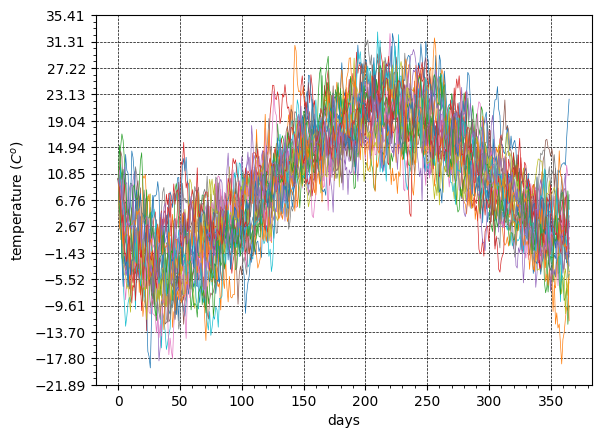

In [30]:
fig2, ax2 = plt.subplots()

for j in range(N_processes):
    ax2.plot(x, T_values[j,:], linewidth=0.5)

ax2.xaxis.set_minor_locator(tk.AutoMinorLocator())
ax2.yaxis.set_major_locator(tk.LinearLocator(numticks=15))
ax2.yaxis.set_minor_locator(tk.AutoMinorLocator())

plt.title('')
plt.xlabel('days')
plt.ylabel('temperature $(C^o)$')
plt.grid(color='black', linestyle='--', lw=0.5)

plt.show()

In [31]:
ref = 18    # Reference temperature
alpha = 50  # Tick size (Call)
beta = 50   # Tick size (Put)
Kc = 3300   # Strike Call
Kp = 3000   # Strike Put
C = 5000    # Cap
F = 10000   # Floor

r = 0.05    # risk free rate
mkt = 0.1   # risk premium

HDD_m = np.maximum(ref - T_values, 0)
cum_HDD = np.sum(HDD_m, axis=1)

csi_c = np.minimum( alpha * np.maximum(cum_HDD - Kc, 0), C) # Call wiht a Cap
csi_p = np.minimum( beta * np.maximum(Kp - cum_HDD, 0), F)  # Put with a Floor

csi_nc = alpha * np.maximum(cum_HDD - Kc, 0)    # Call
csi_np = beta * np.maximum(Kp - cum_HDD, 0)     # Put

collar = csi_c - csi_p      # Collar
strangle = csi_nc + csi_np  # Strangle

pc = collar.mean() * np.exp(-(r + mkt) * (Time/365))     # Price (collar)
ps = strangle.mean() * np.exp(-(r + mkt) * (Time/365))   # Price (strangle)

In [32]:
print(f"collar: {pc:.3f}", f"strangle: {ps:.3f}", sep="\n")

collar: 2543.562
strangle: 8018.177
